# SVM

<Figure size 640x480 with 0 Axes>

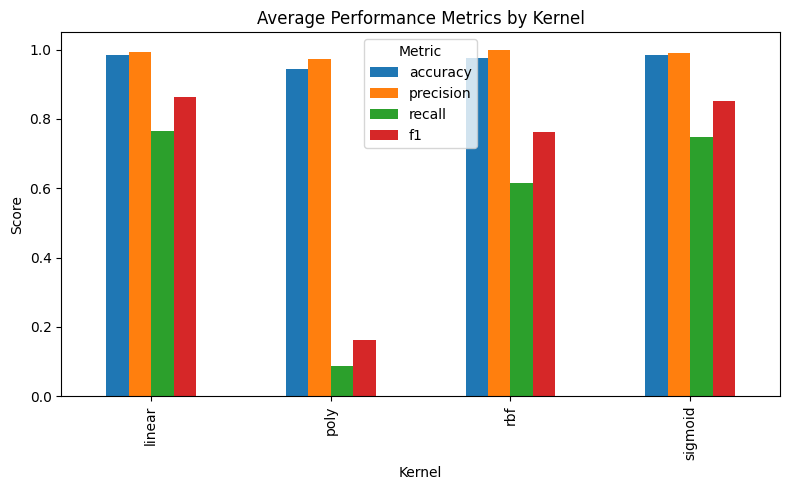

/tmp/ipykernel_518479/1441865803.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=df['kernel'].unique())


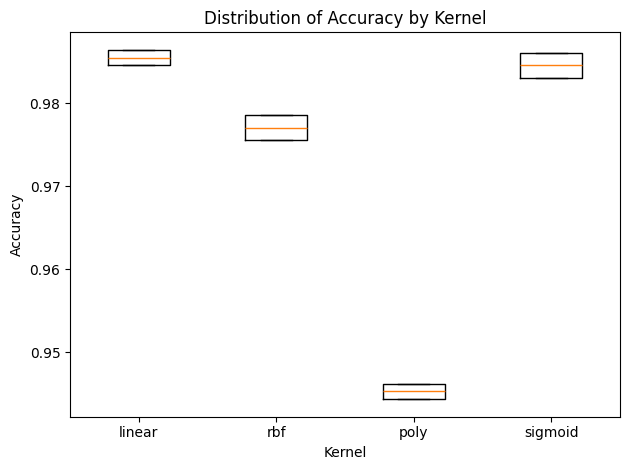

/tmp/ipykernel_518479/1441865803.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=df['kernel'].unique())


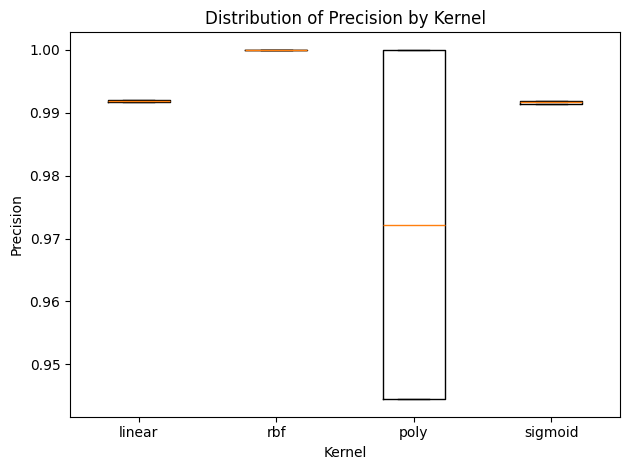

/tmp/ipykernel_518479/1441865803.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=df['kernel'].unique())


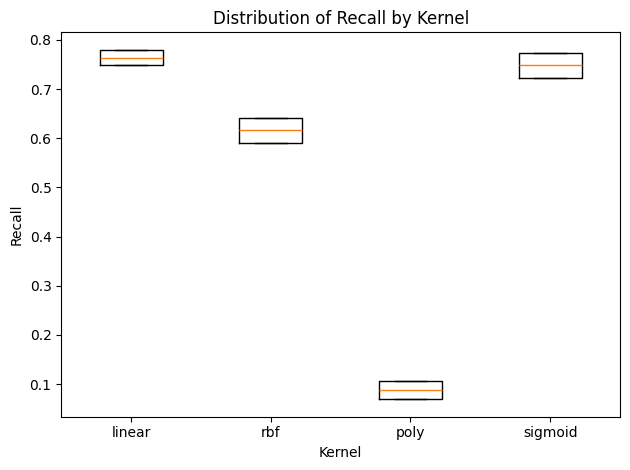

/tmp/ipykernel_518479/1441865803.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=df['kernel'].unique())


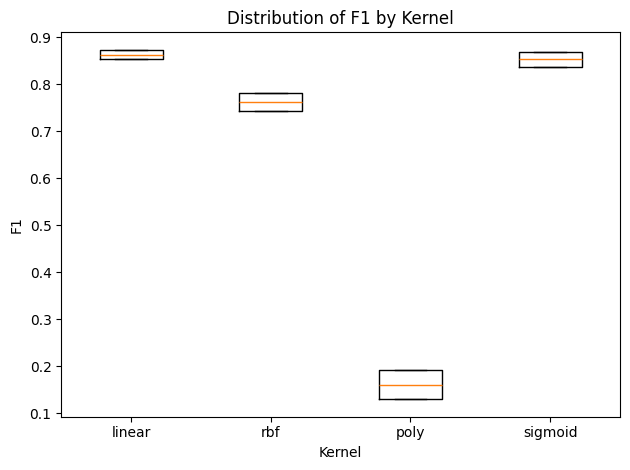

<Figure size 640x480 with 0 Axes>

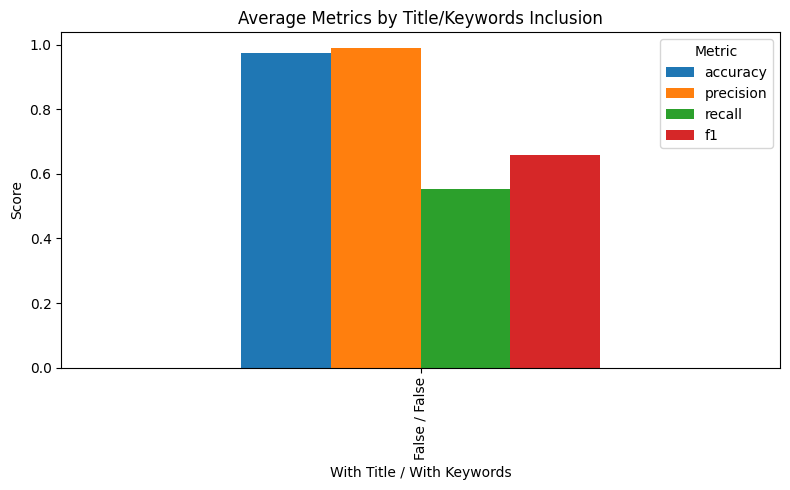

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/metrics/svm_metrics.csv')
df = df.drop(columns=['Unnamed: 0', 'model_name'])

# 1. Mean metrics by kernel
mean_by_kernel = df.groupby('kernel')[['accuracy', 'precision', 'recall', 'f1']].mean()

plt.figure()
mean_by_kernel.plot(kind='bar', figsize=(8, 5))
plt.title('Average Performance Metrics by Kernel')
plt.ylabel('Score')
plt.xlabel('Kernel')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# 2. Boxplot of each metric by kernel
metrics = ['accuracy', 'precision', 'recall', 'f1']
for metric in metrics:
    plt.figure()
    data_to_plot = [df[df['kernel'] == k][metric] for k in df['kernel'].unique()]
    plt.boxplot(data_to_plot, labels=df['kernel'].unique())
    plt.title(f'Distribution of {metric.capitalize()} by Kernel')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Kernel')
    plt.tight_layout()
    plt.show()

# 3. Mean metrics by with_title and with_keywords combinations
df['title_keywords'] = df['with_title'].astype(str) + ' / ' + df['with_keywords'].astype(str)
mean_by_combo = df.groupby('title_keywords')[['accuracy', 'precision', 'recall', 'f1']].mean()

plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


# Random Forest

<Figure size 640x480 with 0 Axes>

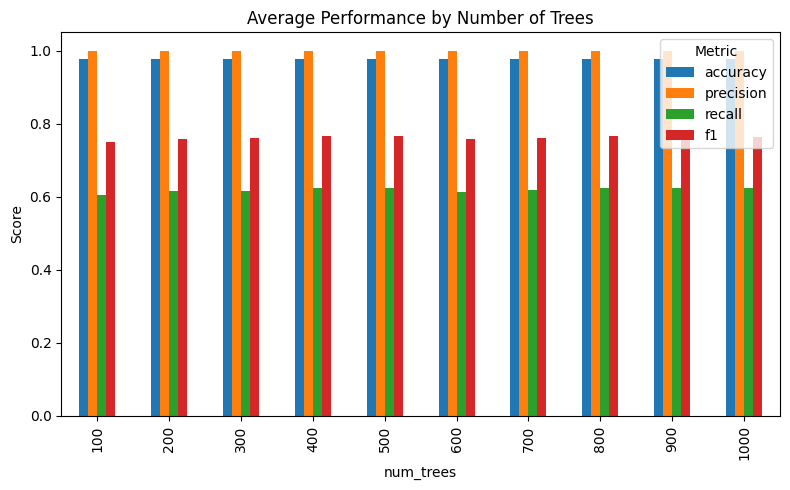

/tmp/ipykernel_518479/2230266865.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=criteria)


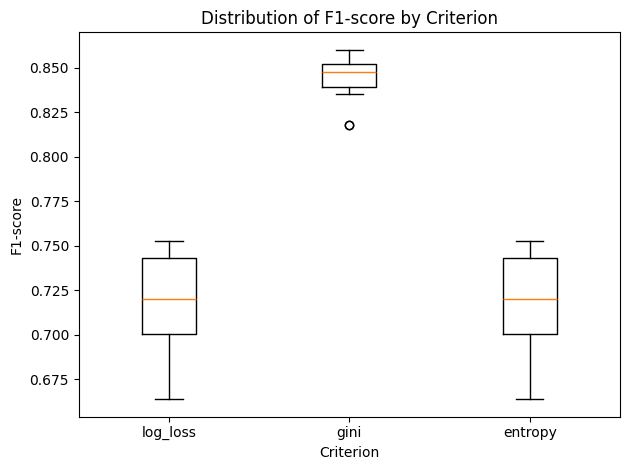

<Figure size 640x480 with 0 Axes>

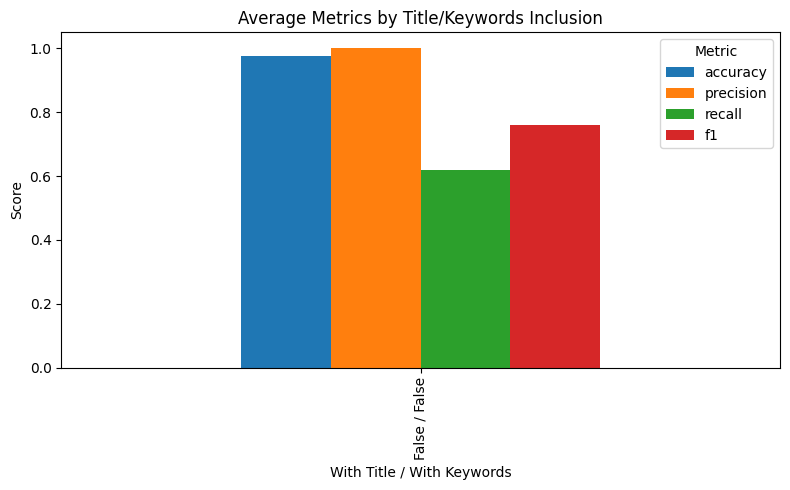

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare the data
df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/metrics/random_forest_metrics.csv')
df = df.drop(columns=['Unnamed: 0', 'model_name'])

import matplotlib.pyplot as plt

# 1. Average metrics by num_trees
mean_by_trees = df.groupby('num_trees')[['accuracy', 'precision', 'recall', 'f1']].mean()
plt.figure()
mean_by_trees.plot(kind='bar', figsize=(8, 5))
plt.title('Average Performance by Number of Trees')
plt.ylabel('Score')
plt.xlabel('num_trees')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# 2. Distribution of F1 by criterion (gini vs log_loss)
plt.figure()
criteria = df['criterion'].unique()
data_to_plot = [df[df['criterion'] == c]['f1'] for c in criteria]
plt.boxplot(data_to_plot, labels=criteria)
plt.title('Distribution of F1-score by Criterion')
plt.ylabel('F1-score')
plt.xlabel('Criterion')
plt.tight_layout()
plt.show()

# 3. Average metrics by Title/Keywords combination
df['title_keywords'] = df['with_title'].astype(str) + ' / ' + df['with_keywords'].astype(str)
mean_by_combo = df.groupby('title_keywords')[['accuracy', 'precision', 'recall', 'f1']].mean()
plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Statistical Test

## Friedman + Nemenyi

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 1) CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────

# Path containing one CSV per model per CV‐fold.
# e.g.:
#   modelA_fold1.csv, modelA_fold2.csv, …, modelB_fold1.csv, …
DATA_DIR = '/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/test preds/bert'  # adjust as needed

# ─────────────────────────────────────────────────────────────────────────────
# 2) LOAD EACH MODEL’S FOLD‐LEVEL CSVs INTO A DICTIONARY
# ─────────────────────────────────────────────────────────────────────────────

all_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
model_data = {}

for fpath in all_files:
    fname = os.path.basename(fpath)
    # Parse “model_name” as the part before the first underscore:
    df = pd.read_csv(fpath)
    model_data.setdefault(fname, []).append(df)


# ─────────────────────────────────────────────────────────────────────────────
# 3) COMPUTE AVERAGE‐PERFORMANCES (e.g. ROC–AUC) PER FOLD
# ─────────────────────────────────────────────────────────────────────────────

perf = {}  # perf[model_name] = list of AUCs, one per CV‐fold

for model_name, dfs in model_data.items():
    aucs = []
    for df in dfs:
        # Each df is exactly one fold of “model_name”
        auc = roc_auc_score(df['label'], df['score'])
        aucs.append(auc)
    perf[model_name] = aucs

# Build a DataFrame of shape (n_folds × n_models):
n_folds = len(next(iter(perf.values())))
fold_idx = list(range(1, n_folds + 1))

perf_df = pd.DataFrame(
    { m: perf[m] for m in perf },
    index=fold_idx
)

print("Per‐fold ROC–AUC for each model:\n")
print(perf_df.round(4))
print("\n")
# ─────────────────────────────────────────────────────────────────────────────
# 4) FRIEDMAN TEST
# ─────────────────────────────────────────────────────────────────────────────

# Friedman’s test takes, as separate arguments, the list of performance‐vectors.
stat, p_value = friedmanchisquare(*[perf_df[col] for col in perf_df.columns])
print(f"Friedman χ² = {stat:.3f},  p‐value = {p_value:.4f}")

if p_value >= 0.05:
    print("→ Friedman test is not significant (p ≥ 0.05). Stop here.")
else:
    print("→ Friedman test is significant (p < 0.05). Proceed to Nemenyi post-hoc.\n")

    # ─────────────────────────────────────────────────────────────────────────
    # 5) NEMENYI POST-HOC (PAIRWISE) TEST
    # ─────────────────────────────────────────────────────────────────────────

    # scikit-posthocs wants a 2D array whose rows are “datasets (folds)” and
    # whose columns are “methods (models)”.  perf_df.values already has shape
    # (n_folds, n_models).
    nemenyi_pvals = sp.posthoc_nemenyi_friedman(perf_df.values)

    # Label rows/columns with model names
    nemenyi_pvals.index = perf_df.columns
    nemenyi_pvals.columns = perf_df.columns

    print("Pairwise Nemenyi p‐values:")
    print(nemenyi_pvals.round(4))
    print("\n")

    # ─────────────────────────────────────────────────────────────────────────
    # 6) CRITICAL‐DIFFERENCE (CD) DIAGRAM
    # ─────────────────────────────────────────────────────────────────────────

    # We need the *average rank* of each model over all folds.
    # Method: rank each row (fold) across columns (models), then average the ranks.
    ranks_df = perf_df.rank(axis=1, method='average')  # shape = (n_folds, n_models)
    avg_ranks = ranks_df.mean(axis=0).values         # length = n_models

    # Compute the critical difference for Nemenyi:
    #   alpha = 0.05 by default → q_alpha is taken from Studentized range
    #   test = 'nemenyi' ensures we use the correct formula.
    cd = sp.compute_CD(
        avg_ranks,
        n=len(perf_df),        # number of “datasets” (folds)
        alpha='0.05',
        test='nemenyi'
    )

    # Now, plot a CD diagram.  graph_ranks(…) expects:
    #   (1) array of average ranks (descending or ascending is fine),
    #   (2) list of corresponding method names,
    #   (3) cd (critical difference)
    plt.figure(figsize=(7, 3))
    sp.graph_ranks(
        avg_ranks,
        list(perf_df.columns),
        cd=cd,
        width=6,
        textspace=1.5
    )
    plt.title("Critical Difference Diagram (Nemenyi, α = 0.05)")
    plt.tight_layout()
    plt.show()


KeyError: 'label'